## Plot spike trains
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg, plot_ccg
from synapticonn.postprocessing import compute_crosscorrelogram

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']
spike_train_1 = all_units[0]/30_000  # unit 0
spike_train_2 = all_units[1]/30_000  # unit 1

Plot spike train.

In [3]:
# import matplotlib.pyplot as plt

# n_cells = all_units['unit_t'].shape[1]

# # plot spike trains for each cell
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# for cell in range(n_cells):
#     ax.eventplot(all_units['unit_t'][0][cell].T, lineoffsets=cell, colors='k', linewidths=0.5)
    
# # axis labels
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Cell #')

# plt.show()

Plot autocorrelograms for individual cells.

Text(379.23787878787874, 0.5, '')

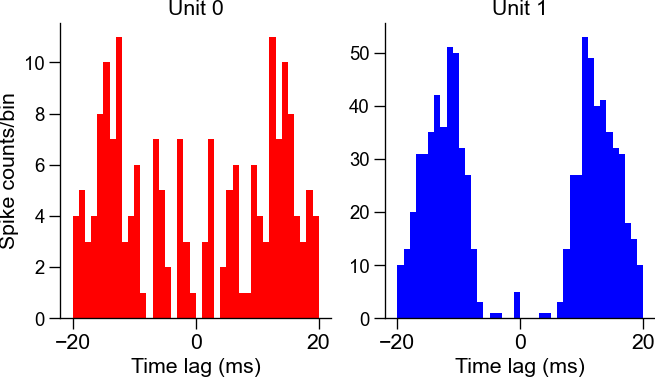

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=False, sharex=True)

# bin parameters
bin_size_ms = 1
max_lag_ms = 20

plot_acg(spike_train_1*1000, bin_size_ms, max_lag_ms, color='red', ax=ax[0])
ax[0].set_title('Unit 0')

plot_acg(spike_train_2*1000, bin_size_ms, max_lag_ms, color='blue', ax=ax[1], file_name='test', file_path='.', extension='png')
ax[1].set_title('Unit 1')
ax[1].set_ylabel('')

Cross-correlogram plots between units.

In [6]:
srate = 30_000

labels = list(all_units.keys())
spike_times_set = list(all_units.values())

if srate: 
    spike_times_set = [spike_times/srate for spike_times in spike_times_set]

bin_size_ms = 0.5
max_lag_ms = 25
cross_correlograms_data = compute_crosscorrelogram(spike_times_set, labels, bin_size_ms, max_lag_ms)

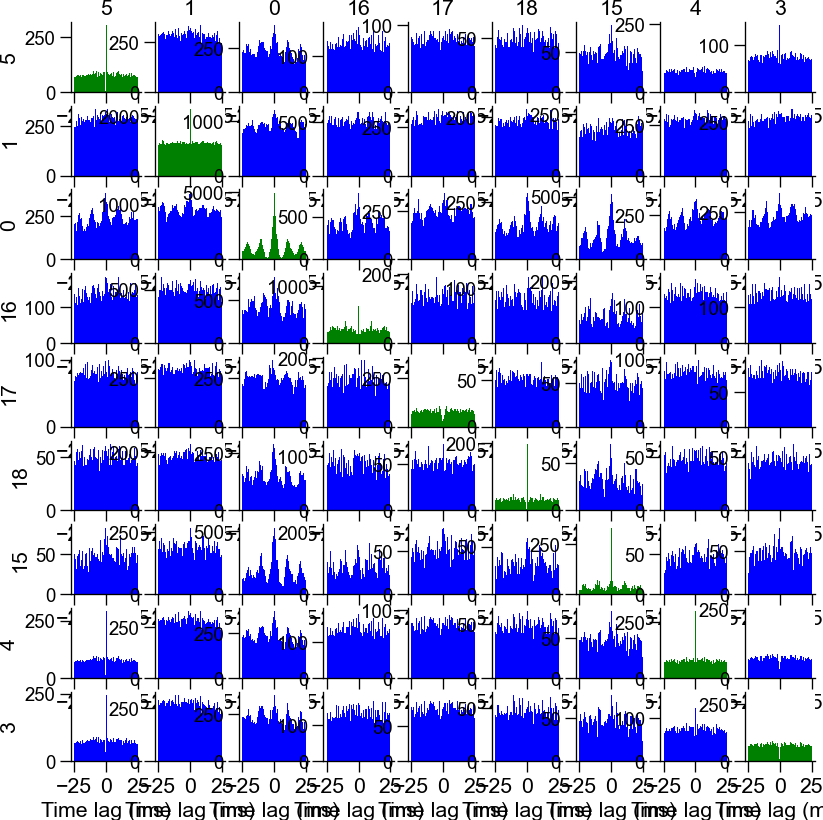

In [7]:
# fig, ax = plt.subplots(9, 9, figsize=(10, 10), sharey=False, sharex=True)
plot_ccg(cross_correlograms_data, labels=labels, ax=None, figsize=(10, 10))
# file_name='test', file_path='.', extension='png'

In [ ]:
# file_name='test', file_path='.', extension='png'

TO DO: 
- Plot for multiple spike trains
    - option to subselect for only 1



- Quality controls
    - Build in quality controls to assess the refractory periods (isi violations)
    - Additional QCs?


- Style is not being fitted globally --> the decorator is useless?

- Cross-Correlation Histogram

- Check the distances between the units?

- Document all the steps in place to check this all out ...

- Option to only plot certain pairs ...

- Option to improve the labels here for the units? Check it with different input types

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Add checks for the correlograms

- Change the file name for the plots for acgs and ccfs

- Integrate the save.py and the settings.mplstyle together?